In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
import warnings

warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_excel("/content/Data_Train.xlsx")

In [ ]:
data.shape

(10683, 11)

In [ ]:
data.dtypes

,0
Airline,object
Date_of_Journey,object
Source,object
Destination,object
Route,object
Dep_Time,object
Arrival_Time,object
Duration,object
Total_Stops,object
Additional_Info,object


Only 'Price' is of integer type rest all are object type.


There exists a row where 'Duration' is 5m which is incorrect.

In [ ]:

duration_5m_rows = data[data['Duration'] == '5m']
duration_5m_rows


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2 stops,No info,17327


The data indicates that the flight time is listed as '5m,' which is clearly inaccurate since it's impossible for a plane to fly from BOMBAY -> GOA -> PUNE -> HYDERABAD in just 5 minutes, especially with 'Total_stops' being 2. Therefore, we decided to drop this row due to the incorrect data.

In [ ]:
data = data[data['Duration'] != '5m']

Count the number of duplicate rows in the dataset to identify redundant data that might need to be removed.

In [ ]:
print("Number of duplicates", data.duplicated().sum())

Number of duplicates 220


Display all duplicate rows in the dataset for inspection to decide whether to keep or remove them

In [ ]:

data[data.duplicated()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303
...,...,...,...,...,...,...,...,...,...,...,...
10594,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,12:35 28 Jun,13h 30m,2 stops,No info,12819
10616,Jet Airways,1/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 02 Jun,26h 55m,2 stops,No info,13014
10634,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 07 Jun,26h 55m,2 stops,In-flight meal not included,11733
10672,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,11150


Remove all duplicate rows from the dataset and update the DataFrame in place.

In [ ]:
data.drop_duplicates(inplace=True)

**DateTime Conversion**

The code converts the 'Date_of_Journey' and 'Dep_Time' columns to datetime format. It also splits the 'Arrival_Time' into time and date components, creating 'A_Time' and 'A_Date'.

**Feature Extraction**

The day and month are extracted from 'Date_of_Journey' and stored in 'Journey_Day' and 'Journey_Month'. Hours and minutes are extracted from 'Dep_Time' and 'Arrival_Time', creating 'Dep_Hours', 'Dep_Minutes', 'Arrival_Hours', and 'Arrival_Minutes'. The 'Duration' column is split into 'Duration_Hours' and 'Duration_Minutes'.

In [ ]:


# Convert 'Date_of_Journey' to datetime
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')

# Convert 'Dep_Time' to datetime; adjust format if necessary
data['Dep_Time'] = pd.to_datetime(data['Dep_Time'])


def parse_datetime(dt_str):
    # Split the string into time and date parts (if available)
    parts = dt_str.split()
    time_str = parts[0]  # Extract time

    # Parse time, assuming format is always HH:MM
    parsed_time = datetime.strptime(time_str, "%H:%M").time()

    # Extract day if available
    day = int(parts[1]) if len(parts) > 1 else None

    # Return time and day of the month as a Series
    return pd.Series([parsed_time, day], index=['Time', 'Date'])

# Apply the function to the 'Arival_Time' column and create new columns
data[['A_Time', 'A_Date']] = data['Arrival_Time'].apply(parse_datetime)

# Extract day and month from 'Date_of_Journey'
data['Journey_Day'] = data['Date_of_Journey'].dt.day
data['Journey_Month'] = data['Date_of_Journey'].dt.month

# Extract hour and minute from 'Dep_Time'
data['Dep_Hours'] = data['Dep_Time'].dt.hour
data['Dep_Minutes'] = data['Dep_Time'].dt.minute



# Extract hour and minute from 'Arrival_Time'
data['Arrival_Hours'] = data['A_Time'].apply(lambda x: x.hour)
data['Arrival_Minutes'] = data['A_Time'].apply(lambda x: x.minute)

# Handle 'Duration' column: Extract hours and minutes
data['Duration_Hours'] = data['Duration'].apply(lambda x: int(x.split('h')[0]) if 'h' in x else 0)
data['Duration_Minutes'] = data['Duration'].apply(lambda x: int(x.split('m')[0].split()[-1]) if 'm' in x else 0)


**Duration and Time Conversion to Minutes**

The code converts the duration, arrival, and departure times into total minutes. It multiplies the 'Duration_Hours', 'Arrival_Hours', and 'Dep_Hours' by 60 and adds the corresponding minutes to create 'Duration_Minutes', 'Arrival_Minutes', and 'Dep_Minutes'.

In [ ]:
data['Duration_Minutes'] = data['Duration_Hours'] * 60 + data['Duration_Minutes']
data['Arrival_Minutes'] = data['Arrival_Hours'] * 60 + data['Arrival_Minutes']
data['Dep_Minutes'] = data['Dep_Hours'] * 60 + data['Dep_Minutes']

In [ ]:
df = data.drop(columns = ['Arrival_Hours', 'Dep_Hours', 'Duration_Hours', 'A_Time', 'Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration'], axis=1)


To standardize the 'Total_Stops' column, we mapped categorical values to numerical equivalents. The mapping converts 'non-stop' to 0, '1 stop' to 1, '2 stops' to 2, '3 stops' to 3, and '4 stops' to 4. This transformation simplifies data analysis by converting categorical information into numerical format.

In [ ]:
df['Total_Stops'] = data['Total_Stops'].map({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4})

Finding null values.

In [ ]:
def count_nulls(df):
    null_counts = df.isnull().sum()
    return null_counts

null_counts_x = count_nulls(df)
null_counts_x


,0
Airline,0
Source,0
Destination,0
Route,1
Total_Stops,1
Additional_Info,0
Price,0
A_Date,6319
Journey_Day,0
Journey_Month,0


We observed that in the dataset, the 'Arrival_Time' includes both time and date (e.g., "01:10 22 Mar") only when the 'Journey_Date' and 'A_Date' are different. Therefore, based on this observation, the null values in 'A_Date' can be filled with the corresponding 'Journey_Date'.

In [ ]:
# Fill NaN values in 'A_Date' column with the corresponding 'Journey_Day' value
df['A_Date'] = df['A_Date'].fillna(df['Journey_Day'])

We identified a null row and filtered the DataFrame to find relevant rows with similar attributes. We replaced the null values in row 9039 with values from row 9075 to ensure data consistency and completeness, as these values were missing but could be reasonably inferred from a similar entry.

In [ ]:
rows_with_nulls = df[df.isnull().any(axis=1)]
print(rows_with_nulls)

        Airline Source Destination Route  Total_Stops Additional_Info  Price  \
9039  Air India  Delhi      Cochin   NaN          NaN         No info   7480   

      A_Date  Journey_Day  Journey_Month  Dep_Minutes  Arrival_Minutes  \
9039     7.0            6              5          585              565   

      Duration_Minutes  
9039              1420  


In [ ]:
# Filter the DataFrame based on the given conditions
filtered_df = df[
    (df['Airline'] == 'Air India') &
    (df['Source'] == 'Delhi') &
    (df['Destination'] == 'Cochin') &
    (df['Duration_Minutes'] == 1420) &
    (df['A_Date'] == 7.0) &
    (df['Journey_Day'] == 6)
]

filtered_df


,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,A_Date,Journey_Day,Journey_Month,Dep_Minutes,Arrival_Minutes,Duration_Minutes
9039,Air India,Delhi,Cochin,NaN,NaN,No info,7480,7.0,6,5,585,565,1420
9075,Air India,Delhi,Cochin,DEL → MAA → COK,1.0,No info,7952,7.0,6,6,585,565,1420


In [ ]:
row_9075_values = df.loc[9075, ['Route', 'Total_Stops']]

# Replace null values in row 9039 with values from row 9075
df.loc[9039, ['Route', 'Total_Stops']] = row_9075_values

We analyzed 'Journey_Day' an 'A_date' and noticed that there exists rows where 'Journey_Day' is greater than 'A_Date'.


In [ ]:
# Find rows where 'Journey_Day' is greater than 'A_Date'

rows_with_date_mismatch = df[df['Journey_Day'] > df['A_Date']]

# Get the number of such rows
num_mismatched_rows = len(rows_with_date_mismatch)

print(f"Number of rows with 'Journey_Day' greater than 'A_Date': {num_mismatched_rows}")

Number of rows with 'Journey_Day' greater than 'A_Date': 89


In [ ]:
rows_with_date_mismatch

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,A_Date,Journey_Day,Journey_Month,Dep_Minutes,Arrival_Minutes,Duration_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,22.0,24,3,1340,70,170
21,Air India,Banglore,New Delhi,BLR → COK → DEL,1.0,No info,6955,19.0,21,3,1320,800,920
110,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1.0,No info,13555,16.0,18,3,845,305,900
379,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1.0,In-flight meal not included,11087,16.0,18,3,1015,540,965
605,Air India,Banglore,New Delhi,BLR → COK → DEL,1.0,No info,6955,19.0,21,3,1320,650,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10441,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1.0,No info,12284,16.0,18,3,700,495,1235
10489,IndiGo,Chennai,Kolkata,MAA → CCU,0.0,No info,6297,13.0,15,3,1325,30,145
10590,Air Asia,Banglore,New Delhi,BLR → DEL,0.0,No info,3383,22.0,24,3,1405,130,165
10638,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1.0,In-flight meal not included,7832,19.0,21,3,1285,685,840


After reviewing these rows, we identified that this issue can be resolved by applying a simple formula: setting 'A_Date' to 'Journey_Day' + 1. Therefore, there's no need to remove these rows.

In [ ]:

# Find rows where 'Journey_Day' is greater than 'A_Date'
rows_to_update = df[df['Journey_Day'] > df['A_Date']]

# Update 'A_Date' in those rows
df.loc[rows_to_update.index, 'A_Date'] = df.loc[rows_to_update.index, 'Journey_Day'] + 1


We also checked for edge cases where 'Journey_Day' is 30 or 31, and 'A_Date' is 1. We found no such cases in the dataset, confirming that our decision to adjust 'A_Date' using the formula 'A_Date = Journey_Day + 1' was correct.








In [ ]:


# Find rows where 'Journey_Day' is 30 or 31 and 'A_Date' is 1
rows_with_date_mismatch = df[(df['Journey_Day'].isin([30, 31]))]

# Get the number of such rows
num_mismatched_rows = len(rows_with_date_mismatch)

print(f"Number of rows with 'Journey_Day' being 30 or 31 and 'A_Date' being 1: {num_mismatched_rows}")


Number of rows with 'Journey_Day' being 30 or 31 and 'A_Date' being 1: 0


In [ ]:
#convert all float64 to int64 and int32 to int 64 for df dataframe

# Select columns with float64 dtype and convert to int64
float_cols = df.select_dtypes(include=['int32']).columns
df[float_cols] = df[float_cols].astype('float64')

# Select columns with int32 dtype and convert to int64
int32_cols = df.select_dtypes(include=['int64']).columns
df[int32_cols] = df[int32_cols].astype('float64')


In [ ]:
df.dtypes

,0
Airline,object
Source,object
Destination,object
Route,object
Total_Stops,float64
Additional_Info,object
Price,float64
A_Date,float64
Journey_Day,float64
Journey_Month,float64


Correlation Matrix

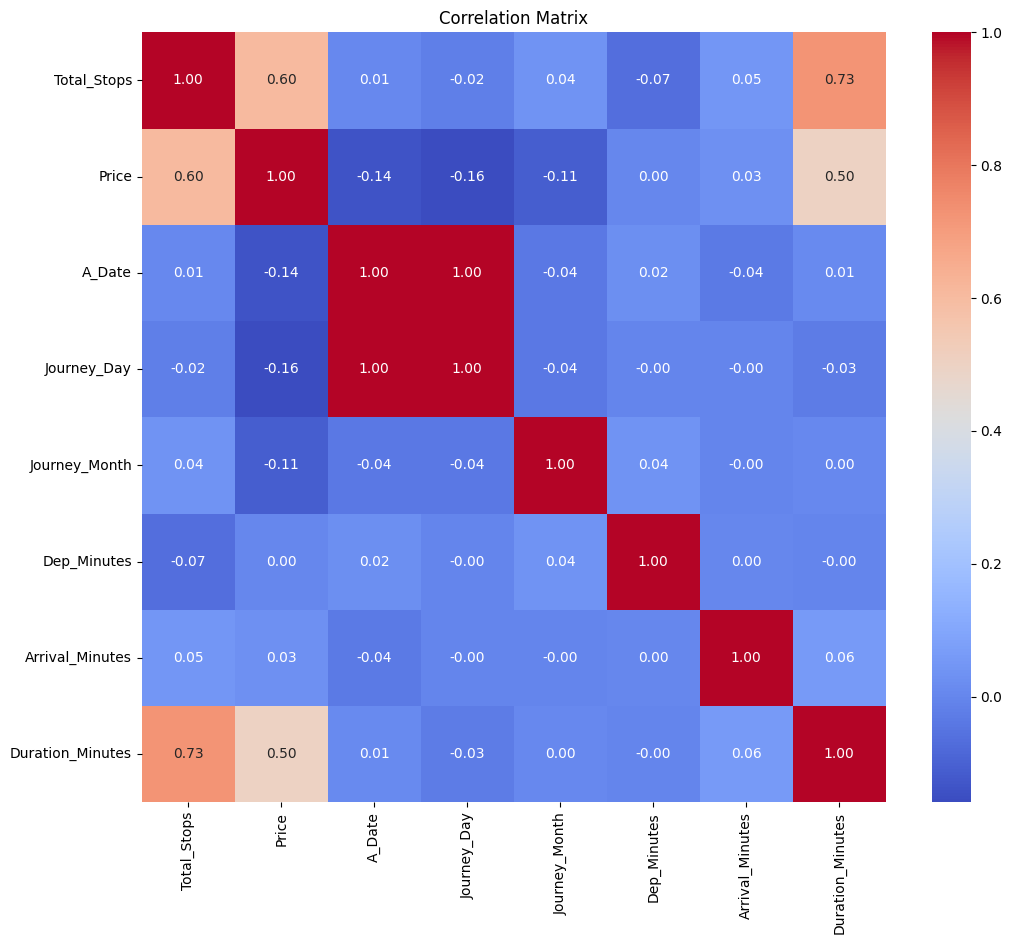

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Price Influencers: 'Total_Stops' and 'Duration_Minutes' have a moderate positive correlation with 'Price,' indicating that more stops and longer durations generally lead to higher prices.
Strong Relationship: A strong correlation exists between 'Total_Stops' and 'Duration_Minutes' (0.83), showing that more stops typically mean longer travel times.
Weak Correlations: Other features like 'Journey_Day,' 'Journey_Month,' 'Dep_Minutes,' and 'Arrival_Minutes' have very weak correlations with 'Price,' suggesting minimal impact on pricing.

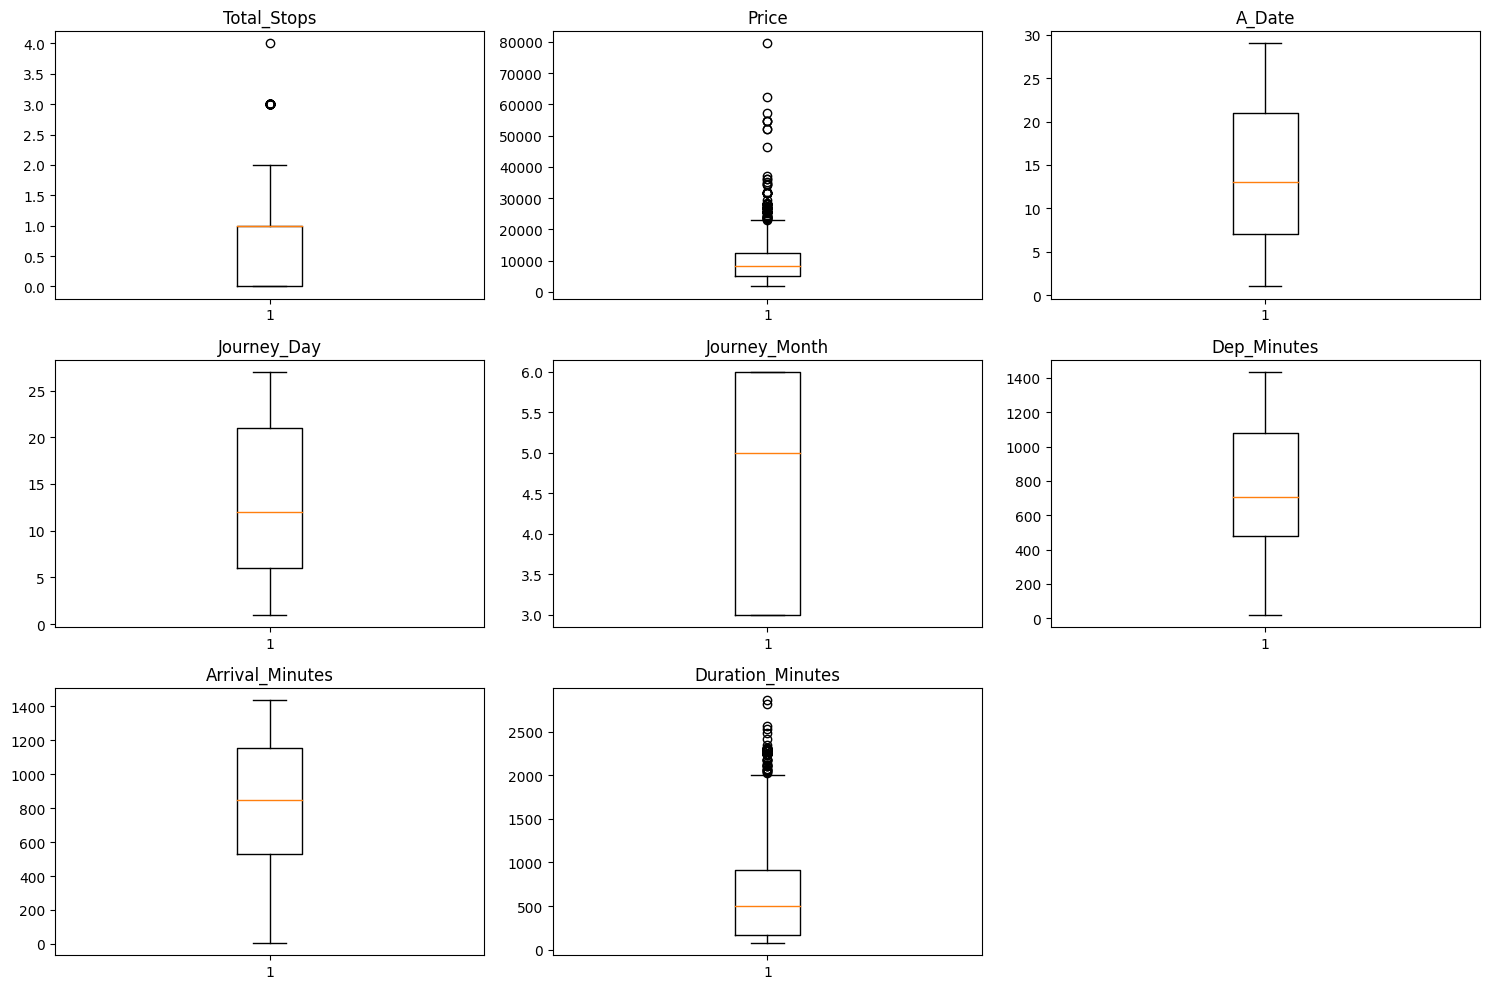

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

We draw the following conclusions:

Outliers are detected in the 'Duration_Minutes', 'Total_Stops' and 'Price' columns.
We will retain the outliers in 'Total_Stops' since the price is influenced by the number of stops.
We will not exclude data with a high number of minutes, as an increase in minutes reflects a price pattern, as seen in the above EDA plots.

Checking for skewnesss.

In [ ]:
numerical_df = df.select_dtypes(include=np.number)

We need to address the skewness in the 'Duration_Minutes' column, using a threshold of +/- 0.5 for skewness. The 'Price' column will not be transformed, as it serves as our target variable.

To correct the skewness, we will apply a log transformation method.


In [ ]:
numerical_df.skew()

,0
Total_Stops,0.332328
Price,1.858373
A_Date,0.119881
Journey_Day,0.124628
Journey_Month,-0.377839
Dep_Minutes,0.122676
Arrival_Minutes,-0.379733
Duration_Minutes,0.903603


In [ ]:
df['Duration_Minutes'] = np.log1p(df['Duration_Minutes'])


 In 'Additional_info' column, where we notice that the 'No info' category appears twice due to the capitalization of the 'I' in 'No Info.' To unify this into a single category, we replace 'No Info' with 'No info.'

In [ ]:
df['Additional_Info'] = df['Additional_Info'].replace('No Info', 'No info')

In [ ]:
#target encode categorical features in df, use target encoder of scikit leran
a = df.drop('Price', axis=1)
b = df['Price']
# Initialize TargetEncoder
encoder = TargetEncoder(cols=['Airline', 'Source', 'Destination', 'Route', 'Additional_Info'])

# Fit and transform the data
df_encoded = encoder.fit_transform(a, b)



In [ ]:
df_encoded

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,A_Date,Journey_Day,Journey_Month,Dep_Minutes,Arrival_Minutes,Duration_Minutes
0,5668.469897,8022.872877,12007.421225,5552.235677,0.0,9073.676604,25.0,24.0,3.0,1340.0,70.0,5.141664
1,9550.795159,9143.083566,9143.083566,8698.130601,2.0,9073.676604,1.0,1.0,5.0,350.0,795.0,6.100319
2,11599.021081,10460.914634,10460.914634,12813.386782,2.0,9073.676604,10.0,9.0,6.0,565.0,265.0,7.039660
3,5668.469897,9143.083566,9143.083566,8339.934522,1.0,9073.676604,12.0,12.0,5.0,1085.0,1410.0,5.786897
4,5668.469897,8022.872877,12007.421225,9379.134447,1.0,9073.676604,1.0,1.0,3.0,1010.0,1295.0,5.655992
...,...,...,...,...,...,...,...,...,...,...,...,...
10678,5590.260188,9143.083566,9143.083566,4556.055249,0.0,9073.676604,9.0,9.0,4.0,1195.0,1345.0,5.017280
10679,9550.795159,9143.083566,9143.083566,4556.055249,0.0,9073.676604,27.0,27.0,4.0,1245.0,1400.0,5.049856
10680,11599.021081,8022.872877,5143.918577,5552.235677,0.0,9073.676604,27.0,27.0,4.0,500.0,680.0,5.198497
10681,7801.355649,8022.872877,12007.421225,5552.235677,0.0,9073.676604,1.0,1.0,3.0,690.0,850.0,5.081404


In [ ]:
X = df_encoded


In [ ]:
y = b

The MinMaxScaler is used to normalize numerical features. By fitting and transforming the data with scaler.fit_transform(X), the values in X are scaled to a range between 0 and 1. This process helps in ensuring that all numerical features contribute equally to the model, improving its performance and convergence.

In [ ]:
scaler = MinMaxScaler()
# Fit and transform the numerical features
X_pre= scaler.fit_transform(X)

In [ ]:
X_pre

array([[0.09223085, 0.57008778, 1.        , ..., 0.93286219, 0.04545455,
        0.22350801],
       [0.36092557, 0.76762019, 0.6031415 , ..., 0.23321555, 0.55244755,
        0.48773192],
       [0.50268275, 1.        , 0.78572907, ..., 0.38515901, 0.18181818,
        0.74663252],
       ...,
       [0.50268275, 0.57008778, 0.04905089, ..., 0.33922261, 0.47202797,
        0.23917241],
       [0.23984732, 0.57008778, 1.        , ..., 0.47349823, 0.59090909,
        0.20689941],
       [0.36092557, 1.        , 0.78572907, ..., 0.44876325, 0.8041958 ,
        0.5197829 ]])

In [ ]:
# Define a hyperparameter search space for BaggingCLassifier and XGBClassifier
space = {
        'n_estimators' : hp.choice('n_estimators', [850, 900, 950, 1000, 1050, 1100, 1150, 1200]),
        'max_depth': hp.choice('max_depth', range(2, 13)),
        'learning_rate': hp.uniform('learning_rate', 0.0008, 0.009),
        'min_child_weight': hp.uniform('min_child_weight', 1, 18),
        'gamma': hp.loguniform('gamma', low=np.log(0.001), high=np.log(5)),  # Gamma from 0 to 5 (log-uniform)
        'reg_alpha': hp.loguniform('reg_alpha', low=np.log(0.0001), high=np.log(0.8)),  # Alpha from 0 to 0.8 (log-uniform)
        'reg_lambda': hp.loguniform('reg_lambda', low=np.log(1), high=np.log(5)),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
        'colsample_bynode': hp.uniform('colsample_bynode', 0.6, 1.0),
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.6, 1.0)
    }

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def objective(space):

    # Flatten the target variable y
    y_data  = y.values.ravel()
    # Define the BaggingClassifier with XGBClassifier as the base estimator
    model = XGBRegressor(
                        random_state=42, device='cuda', **space, objective='reg:squarederror', n_jobs = -1)

    xgb_cv = cross_val_score(model, X_pre, y_data, scoring='r2', cv=kf)
    mean_r2 = np.mean(xgb_cv)

    # Return loss (negative mean accuracy) and optimization status
    return {'loss': -mean_r2, 'status': STATUS_OK}

# Run hyperparameter optimization using Hyperopt
trials = Trials()
best_params = fmin(objective, space, rstate=np.random.default_rng(42), algo=tpe.suggest,
                   max_evals=100, trials=trials)
# Print best hyperparameters found
print("Best hyperparameters:", best_params)

100%|██████████| 100/100 [43:26<00:00, 26.06s/trial, best loss: -0.9228444339190668]
Best hyperparameters: {'colsample_bylevel': 0.8475968127785966, 'colsample_bynode': 0.6255283156156687, 'colsample_bytree': 0.9527627696603798, 'gamma': 2.625967403728718, 'learning_rate': 0.008614511483946615, 'max_depth': 10, 'min_child_weight': 1.196985401325954, 'n_estimators': 6, 'reg_alpha': 0.01112713927546199, 'reg_lambda': 2.334303028861373}


In [ ]:
best_params = {'colsample_bylevel': 0.8475968127785966, 'colsample_bynode': 0.6255283156156687, 'colsample_bytree': 0.9527627696603798, 'gamma': 2.625967403728718, 'learning_rate': 0.008614511483946615, 'max_depth': 12,
               'min_child_weight': 1.196985401325954, 'n_estimators': 1150,
               'reg_alpha': 0.01112713927546199, 'reg_lambda': 2.334303028861373}

In [ ]:
def evaluate():

    y_data  = y.values.ravel()
    r2_test = []
    r2_train = []


    # Flatten the target variable y
    y_data  = y.values.ravel()
    model = XGBRegressor(
                        random_state=42, **best_params, objective='reg:squarederror', n_jobs = -1) # Use best_params instead of space
    for train_index, test_index in kf.split(X_pre, y):
        X_train_kf = X_pre[train_index]
        X_test_kf = X_pre[test_index]
        y_train_kf, y_test_kf = y_data[train_index], y_data[test_index] # Index y_data (NumPy array) instead of y (Series)
        # y_train_kf = y_train_kf.values.ravel()  # No need to ravel again
        # y_test_kf = y_test_kf.values.ravel()  # No need to ravel again
        # Fit the model
        model.fit(X_train_kf, y_train_kf)

        # Predict on the test set
        y_test_pred_kf = model.predict(X_test_kf)
        y_train_pred_kf = model.predict(X_train_kf)
        # Calculate R2 scores
        r2_test_kf = r2_score(y_test_kf, y_test_pred_kf)
        r2_train_kf = r2_score(y_train_kf, y_train_pred_kf)
        r2_test.append(r2_test_kf)
        r2_train.append(r2_train_kf)

    # Print mean F1 score and mean demographic parity ratio
    print("Train R2 Score", np.mean(r2_train))
    print("Test R2 Score", np.mean(r2_test)) # Fix typo: r2_tests -> r2_test

# Call the evaluate function
print("call evaluate function")
evaluate()

call evaluate function
Train R2 Score 0.9877708093216316
Test R2 Score 0.9228444339190668


In [ ]:
data= pd.read_excel("/content/Test_set (1).xlsx")


In [ ]:

print("Number of duplicates", data.duplicated().sum())
data[data.duplicated()]
data.drop_duplicates(inplace=True)


# Convert 'Date_of_Journey' to datetime
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')

# Convert 'Dep_Time' to datetime; adjust format if necessary
data['Dep_Time'] = pd.to_datetime(data['Dep_Time'])


def parse_datetime(dt_str):
    # Split the string into time and date parts (if available)
    parts = dt_str.split()
    time_str = parts[0]  # Extract time

    # Parse time, assuming format is always HH:MM
    parsed_time = datetime.strptime(time_str, "%H:%M").time()

    # Extract day if available
    day = int(parts[1]) if len(parts) > 1 else None

    # Return time and day of the month as a Series
    return pd.Series([parsed_time, day], index=['Time', 'Date'])

# Apply the function to the 'Arival_Time' column and create new columns
data[['A_Time', 'A_Date']] = data['Arrival_Time'].apply(parse_datetime)

# Extract day and month from 'Date_of_Journey'
data['Journey_Day'] = data['Date_of_Journey'].dt.day
data['Journey_Month'] = data['Date_of_Journey'].dt.month

# Extract hour and minute from 'Dep_Time'
data['Dep_Hours'] = data['Dep_Time'].dt.hour
data['Dep_Minutes'] = data['Dep_Time'].dt.minute



# Extract hour and minute from 'Arrival_Time'
data['Arrival_Hours'] = data['A_Time'].apply(lambda x: x.hour)
data['Arrival_Minutes'] = data['A_Time'].apply(lambda x: x.minute)

# Handle 'Duration' column: Extract hours and minutes
data['Duration_Hours'] = data['Duration'].apply(lambda x: int(x.split('h')[0]) if 'h' in x else 0)
data['Duration_Minutes'] = data['Duration'].apply(lambda x: int(x.split('m')[0].split()[-1]) if 'm' in x else 0)

data['Duration_Minutes'] = data['Duration_Hours'] * 60 + data['Duration_Minutes']
data['Arrival_Minutes'] = data['Arrival_Hours'] * 60 + data['Arrival_Minutes']
data['Dep_Minutes'] = data['Dep_Hours'] * 60 + data['Dep_Minutes']

df = data.drop(columns = ['Arrival_Hours', 'Dep_Hours', 'Duration_Hours', 'A_Time', 'Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration'], axis=1)

df['Total_Stops'] = data['Total_Stops'].map({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4})


# Fill NaN values in 'A_Date' column with the corresponding 'Journey_Day' value
df['A_Date'] = df['A_Date'].fillna(df['Journey_Day'])

rows_with_nulls = df[df.isnull().any(axis=1)]
print(rows_with_nulls)

# Filter the DataFrame based on the given conditions
filtered_df = df[
    (df['Airline'] == 'Air India') &
    (df['Source'] == 'Delhi') &
    (df['Destination'] == 'Cochin') &
    (df['Duration_Minutes'] == 1420) &
    (df['A_Date'] == 7.0) &
    (df['Journey_Day'] == 6)
]

filtered_df

Number of duplicates 26
Empty DataFrame
Columns: [Airline, Source, Destination, Route, Total_Stops, Additional_Info, A_Date, Journey_Day, Journey_Month, Dep_Minutes, Arrival_Minutes, Duration_Minutes]
Index: []


,Airline,Source,Destination,Route,Total_Stops,Additional_Info,A_Date,Journey_Day,Journey_Month,Dep_Minutes,Arrival_Minutes,Duration_Minutes
1091,Air India,Delhi,Cochin,DEL → HYD → MAA → COK,2,No info,7.0,6,3,585,565,1420
1119,Air India,Delhi,Cochin,DEL → MAA → COK,1,No info,7.0,6,4,585,565,1420
1307,Air India,Delhi,Cochin,DEL → BOM → COK,1,No info,7.0,6,3,480,460,1420
2531,Air India,Delhi,Cochin,DEL → MAA → COK,1,No info,7.0,6,3,585,565,1420
2643,Air India,Delhi,Cochin,DEL → HYD → MAA → COK,2,No info,7.0,6,6,585,565,1420


Number of rows with 'Journey_Day' greater than 'A_Date': 23
Number of rows with 'Journey_Day' being 30 or 31 and 'A_Date' being 1: 0


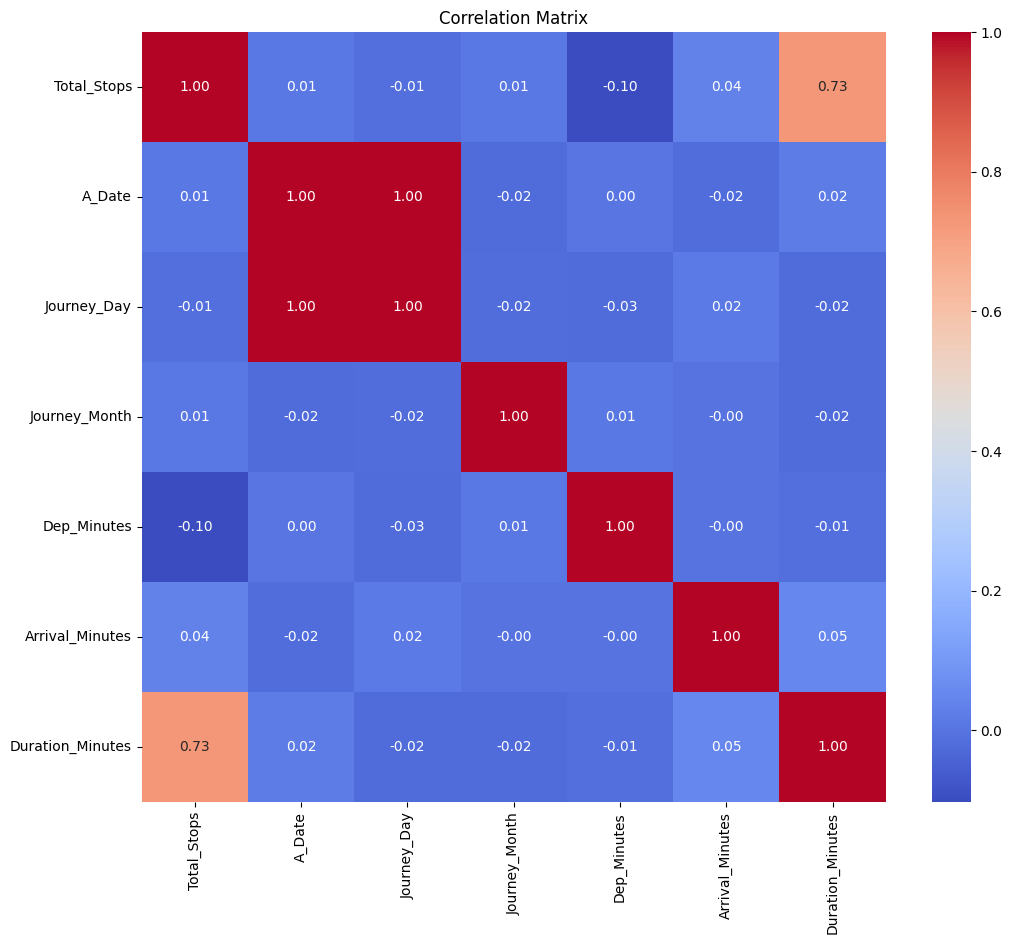

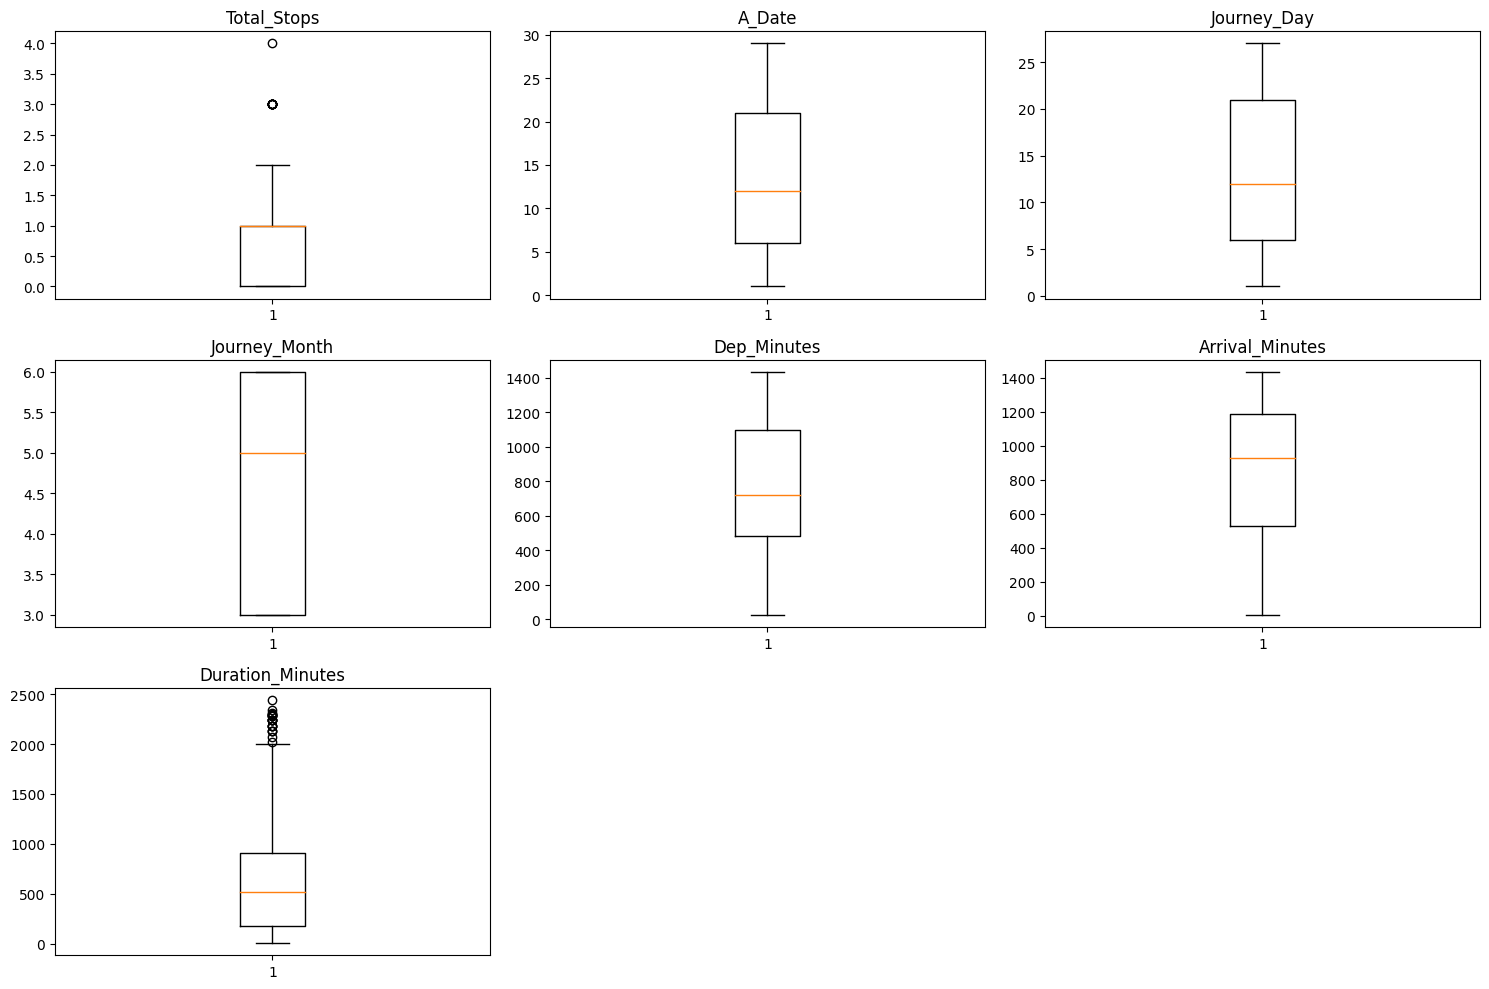

In [ ]:

# Find rows where 'Journey_Day' is greater than 'A_Date'

rows_with_date_mismatch = df[df['Journey_Day'] > df['A_Date']]

# Get the number of such rows
num_mismatched_rows = len(rows_with_date_mismatch)

print(f"Number of rows with 'Journey_Day' greater than 'A_Date': {num_mismatched_rows}")

# Find rows where 'Journey_Day' is greater than 'A_Date'
rows_to_update = df[df['Journey_Day'] > df['A_Date']]

# Update 'A_Date' in those rows
df.loc[rows_to_update.index, 'A_Date'] = df.loc[rows_to_update.index, 'Journey_Day'] + 1

#find rows in df where journey_of_day is 30 or 31 and A_date is 1 and give me number of these rows

# Find rows where 'Journey_Day' is 30 or 31 and 'A_Date' is 1
rows_with_date_mismatch = df[(df['Journey_Day'].isin([30, 31]))]

# Get the number of such rows
num_mismatched_rows = len(rows_with_date_mismatch)

print(f"Number of rows with 'Journey_Day' being 30 or 31 and 'A_Date' being 1: {num_mismatched_rows}")

#convert all float64 to int64 and int32 to int 64 for df dataframe

float_cols = df.select_dtypes(include=['int32']).columns
df[float_cols] = df[float_cols].astype('float64')

# Select columns with int32 dtype and convert to int64
int32_cols = df.select_dtypes(include=['int64']).columns
df[int32_cols] = df[int32_cols].astype('float64')

df.dtypes

numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

numerical_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

numerical_df = df.select_dtypes(include=np.number)

numerical_df.skew()

df['Duration_Minutes'] = np.log1p(df['Duration_Minutes'])

numerical_df.skew()
df['Additional_Info'] = df['Additional_Info'].replace('No Info', 'No info')


# Fit and transform the data
df_encoded = encoder.transform(df)




In [ ]:
scaler = MinMaxScaler()
# Fit and transform the numerical features
test = scaler.fit_transform(df_encoded)

In [ ]:
y_data  = y.values.ravel()
model = XGBRegressor(random_state=42, **best_params, objective='reg:squarederror', n_jobs = -1)
model.fit(X_pre, y_data)
p = model.predict(test)

In [ ]:


# Combine test_data and predictions into a DataFrame
result_df = pd.DataFrame({'Price': p})
# Convert the NumPy array 'test' to a DataFrame before concatenation
test_df = pd.DataFrame(test)
result_df = pd.concat([test_df, result_df], axis=1)

In [ ]:
result_df

,0,1,2,3,4,5,6,7,8,9,10,11,Price
0,0.502683,1.000000,0.785729,0.592417,0.25,0.404998,0.214286,0.192308,1.000000,0.726950,0.181818,0.781306,14618.849609
1,0.092231,0.767620,0.603142,0.113874,0.25,0.404998,0.392857,0.423077,0.666667,0.251773,0.430070,0.614645,4941.497070
2,0.502683,1.000000,0.785729,0.592417,0.25,0.431990,0.750000,0.769231,0.666667,0.801418,0.793706,0.910536,12737.358398
3,0.454489,1.000000,0.785729,0.592417,0.25,0.404998,0.714286,0.769231,0.666667,0.322695,0.877622,0.810334,10040.375977
4,0.086818,0.570088,0.049051,0.136636,0.00,0.404998,0.857143,0.884615,1.000000,1.000000,0.111888,0.557536,5104.235840
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,0.360926,0.767620,0.603142,0.576306,0.25,0.404998,0.214286,0.192308,1.000000,0.854610,0.853147,0.911699,10130.115234
2641,0.092231,0.767620,0.603142,0.052585,0.00,0.404998,0.928571,1.000000,0.000000,0.592199,0.706294,0.542257,5408.741211
2642,0.502683,1.000000,0.785729,0.592417,0.25,0.404998,0.214286,0.192308,0.000000,0.911348,0.181818,0.697299,16322.484375
2643,0.360926,1.000000,0.785729,0.592417,0.25,0.404998,0.178571,0.192308,0.000000,0.152482,0.804196,0.836871,12934.901367


,0
Airline,0
Source,0
Destination,0
Route,0
Total_Stops,0
Additional_Info,0
A_Date,0
Journey_Day,0
Journey_Month,0
Dep_Minutes,0
